In [41]:
import yfinance as yf
import json
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import dates as mdates
import numpy as np 

%matplotlib inline

plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (30, 10)

In [3]:
stock_dir_path = str(Path(os.path.abspath('')).parents[0] / 'data/stock_data/')
tickers_path = str(Path(os.path.abspath('')).parents[0] / 'data/stocksTickers.json')

In [4]:
tickers_path = str(Path(os.path.abspath('')).parents[0] / 'data/stocksTickers.json')
with open(tickers_path) as ticker_names: 
    names = json.load(ticker_names)

In [5]:
def download_yfinance_data(names_dict, peroid='10y', dir_path=stock_dir_path): 

    for ticker_name, name in names_dict.items(): 
        ticker = yf.Ticker(ticker_name)
        data = ticker.history(period=peroid)
        data.to_csv(str(Path(dir_path) / f'{name.lower()}.csv'))

In [6]:
download_yfinance_data(names_dict=names)

In [7]:
def load_all_stocks_data(stock_path=stock_dir_path):
    data_dict = {}
    for filename in os.listdir(stock_dir_path): 
        data_dict[filename.split('.')[0]] = pd.read_csv(str(Path(stock_path) / filename))
        
    return data_dict

In [8]:
data_dict = load_all_stocks_data()

In [9]:
def plot_all_prices(data_dict, x_col, y_col, one_figsize:list, minticks=20, maxticks=30): 
    
    number_of_plots = len(data_dict)
    _, axes = plt.subplots(number_of_plots, 1, figsize=(one_figsize[0], one_figsize[1] * number_of_plots))

    for ax, (company, data) in zip(axes, data_dict.items()):
        ax.plot(data[x_col], data[y_col])
        ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks))
        ax.set_title(f'{company.capitalize()} close stock price in past 10 years.', size=25)
        ax.set_xlabel('Time', size=15)
        ax.set_ylabel('Price in $', size=15)
    
    plt.show()

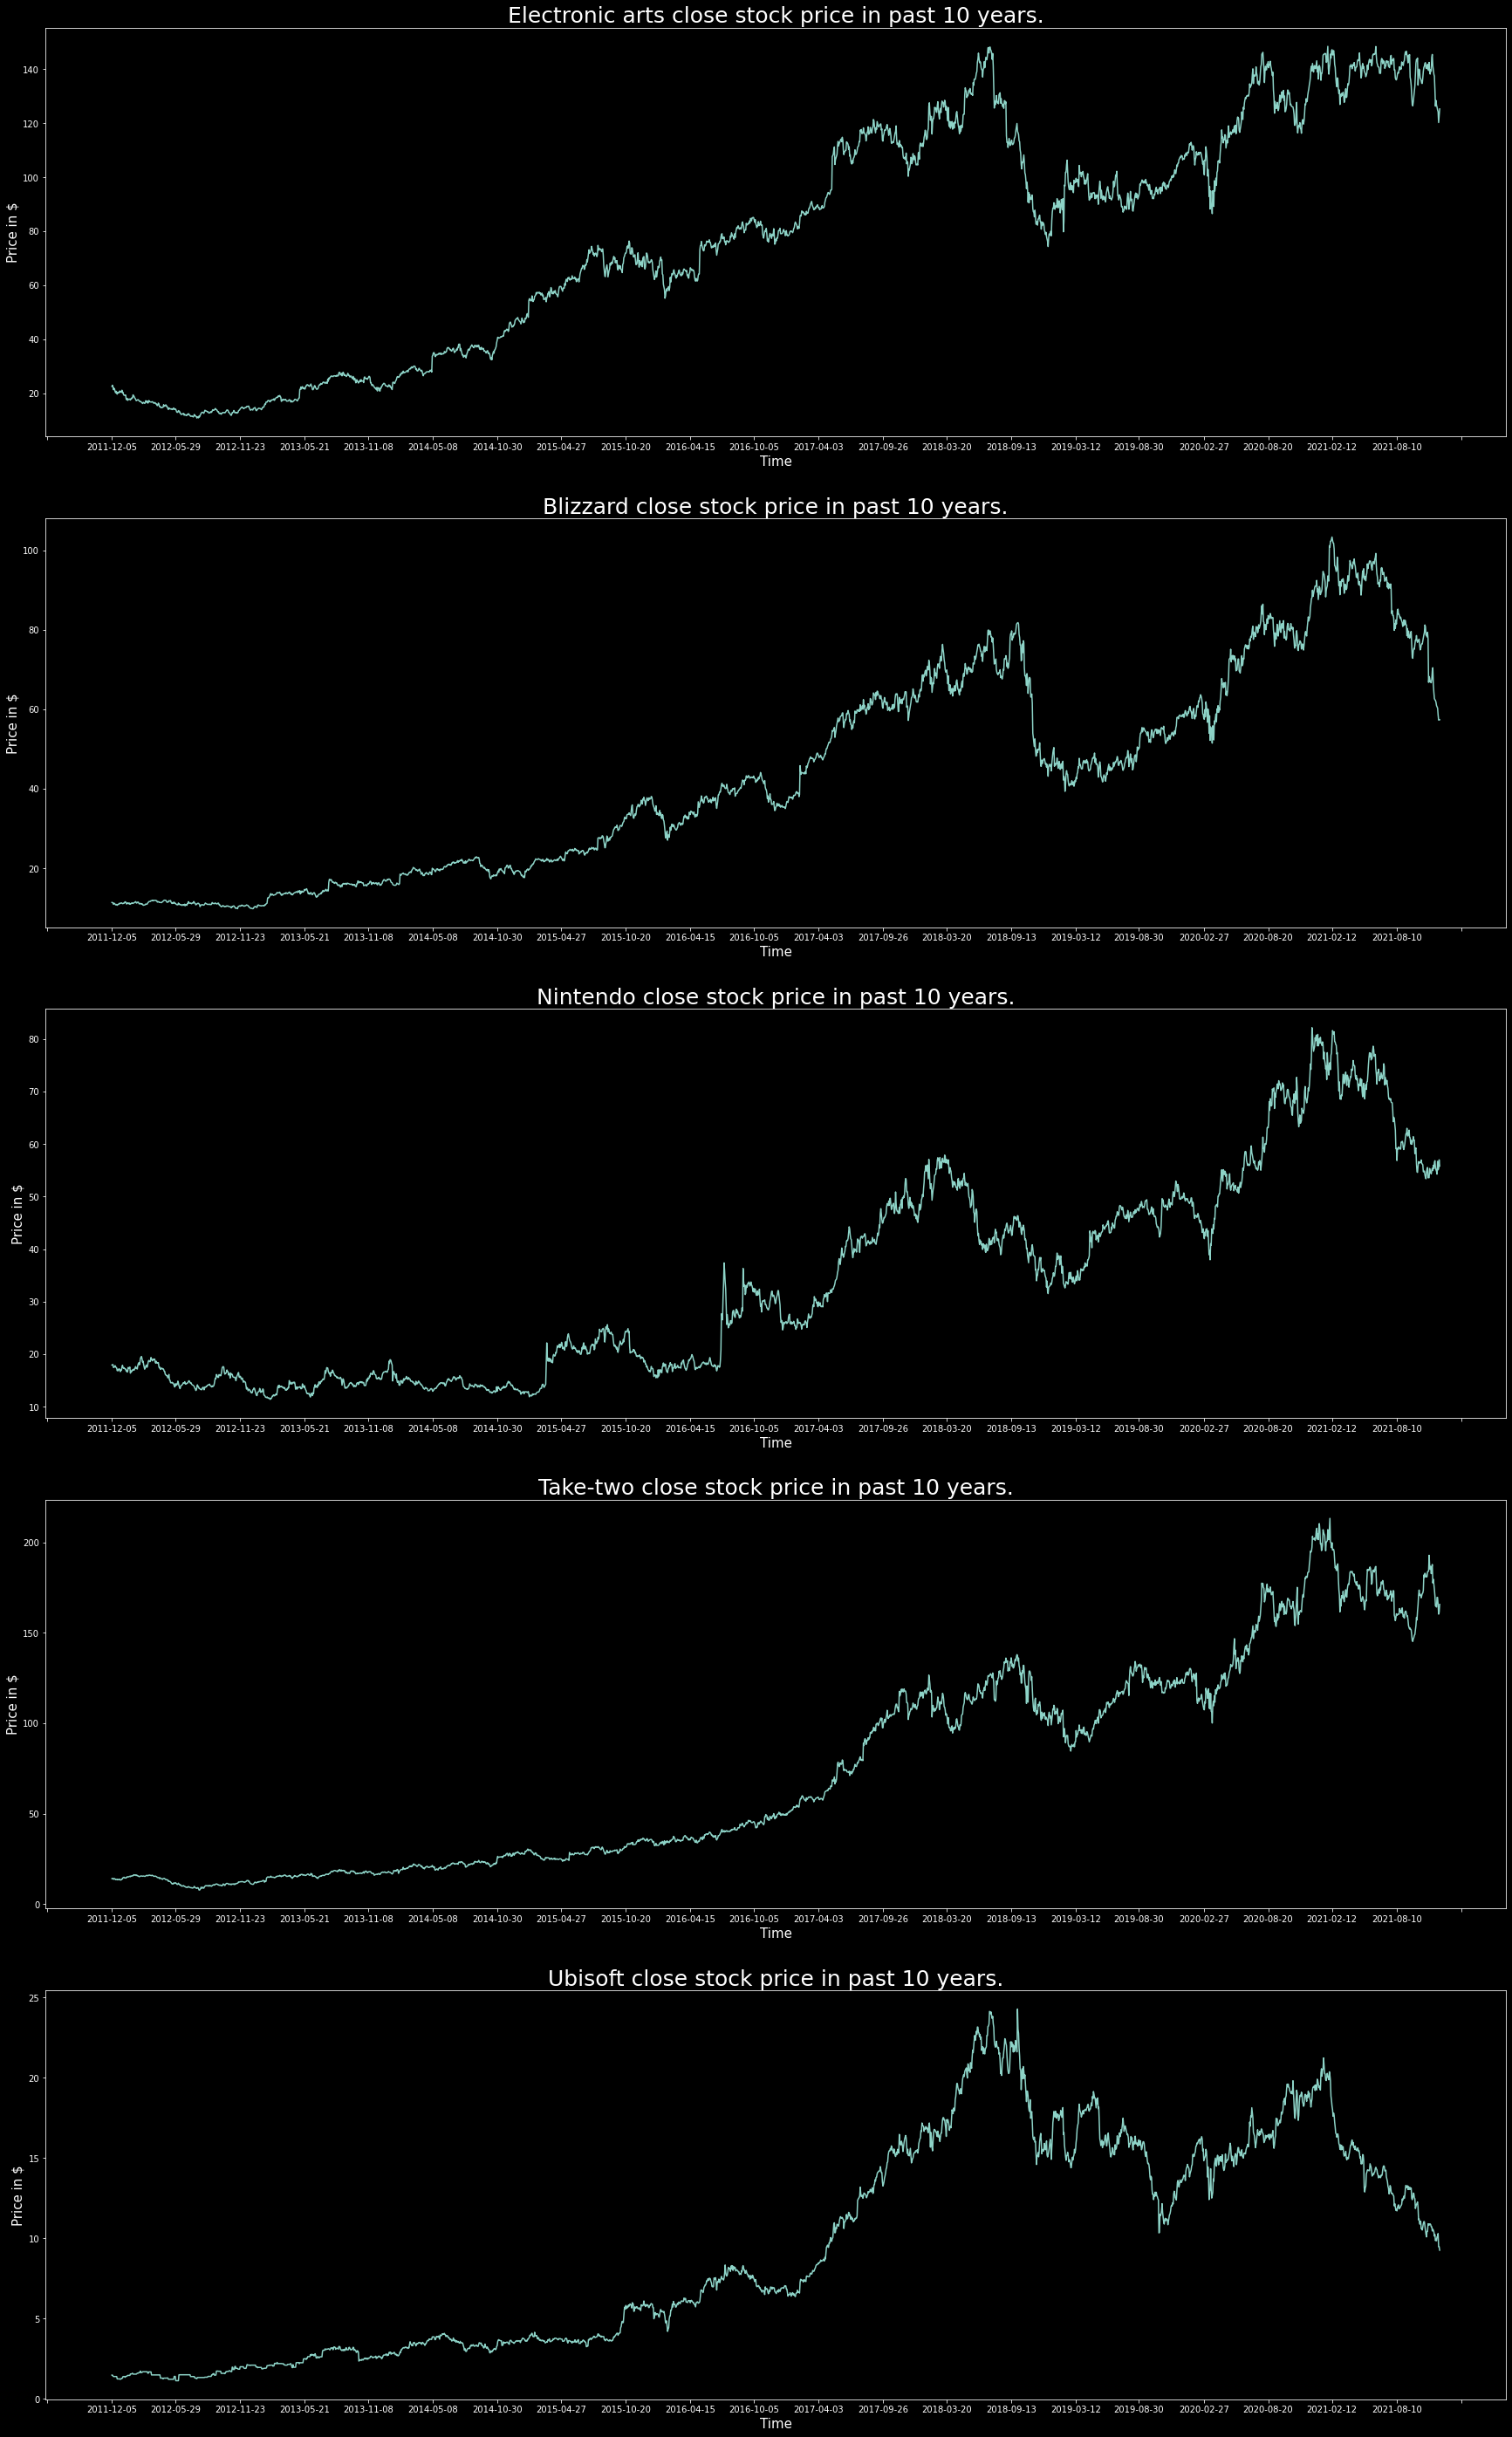

In [10]:
plot_all_prices(data_dict, 'Date', 'Close', [30, 10])

# Preparation of Technical Indicators 

## 1. Simple moving averages 

In [24]:
data = pd.DataFrame(columns=data_dict['blizzard'].columns)
for df in list(data_dict.values()): 
    data.append(df)

blizzard = data['blizzard']

In [45]:
peroid_list = [5, 10, 20, 50, 100, 200]

for name, df in data_dict.items(): 
    for peroid in peroid_list: 
        df[f'sma_{peroid}'] = df['Close'].rolling(window=peroid).mean()
        df[f'ema_{peroid}'] = df['Close'].ewm(span=peroid).mean()
        
        weights = np.arange(1, peroid + 1)
        df[f'wma_{peroid}'] = (df['Close'].rolling(window=peroid)
                                          .apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True))


## 2. Exponential moving averages

In [46]:
data_dict['blizzard']

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,sma_5,sma_10,...,ema_20,ema_50,ema_100,ema_200,wma_5,wma_10,wma_20,wma_50,wma_100,wma_200
0,2011-12-05,11.370403,11.553944,11.333694,11.416287,9878600,0.0,0,NaN,NaN,...,11.416287,11.416287,11.416287,11.416287,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-12-06,11.462174,11.489706,11.333695,11.361226,10028800,0.0,0,NaN,NaN,...,11.387380,11.388206,11.388481,11.388619,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-07,11.306163,11.361226,11.205216,11.260279,10342600,0.0,0,NaN,NaN,...,11.340709,11.343847,11.344890,11.345410,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-08,11.150153,11.269455,10.939080,10.948257,10323100,0.0,0,NaN,NaN,...,11.227415,11.238938,11.242737,11.244628,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-09,11.003320,11.296987,10.984966,11.232747,10545500,0.0,0,11.243759,NaN,...,11.228704,11.237599,11.240659,11.242204,11.191756,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2021-11-29,60.889999,60.950001,59.650002,60.310001,7749600,0.0,0,61.162000,63.163000,...,66.117536,71.714251,77.017809,81.098795,60.833334,61.808000,64.147857,70.188832,74.395218,81.389671
2513,2021-11-30,60.020000,60.430000,58.439999,58.599998,19291100,0.0,0,60.442000,61.980000,...,65.401580,71.199966,76.653100,80.874927,59.979333,60.978363,63.399143,69.633200,74.002992,81.113397
2514,2021-12-01,59.110001,59.209999,57.189999,57.279999,11607000,0.0,0,59.543999,61.093999,...,64.628096,70.654085,76.269474,80.640151,58.925333,60.123818,62.623524,69.039592,73.591317,80.826170
2515,2021-12-02,57.279999,58.180000,56.619999,57.290001,8606200,0.0,0,58.820000,60.403000,...,63.929230,70.130003,75.893643,80.407812,58.174000,59.432182,61.945952,68.458730,73.186895,80.541261


In [34]:
blizzard['Close'].ewm(span=10).mean()

0       11.416287
1       11.386004
2       11.335463
3       11.207896
4       11.215030
          ...    
2512    62.979553
2513    62.183270
2514    61.291766
2515    60.564172
2516    59.981596
Name: Close, Length: 2517, dtype: float64